In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def fill_holes(mask):
    contours, hierarchy = cv.findContours(mask, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)    
    for i, contour in enumerate(contours):
        cv.drawContours(mask, [contour], 0, 255, -1)
    
    return mask


In [4]:
def clean_image(img):
    for i in range(len(img)):
        black_pixels = np.sum(img[i] == [0, 0, 0], axis=-1)
        total_black_pixels = np.sum(black_pixels == 3)

        if total_black_pixels > len(img[i]) / 3:
            img[i, :] = [0, 0, 0]
    
    return img

# Segmentacion del Cielo

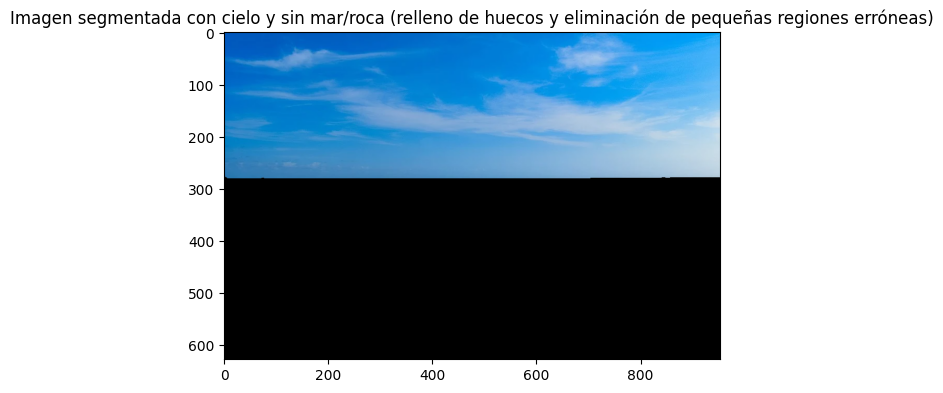

In [5]:
img_color = cv.imread('segmentacion.png')

if img_color is None:
    print("La imagen no se cargó correctamente")
else:
    img_hsv = cv.cvtColor(img_color, cv.COLOR_BGR2HSV)
    lower_blue = np.array([90, 150, 150])
    upper_blue = np.array([130, 255, 255])

    mask_sky = cv.inRange(img_hsv, lower_blue, upper_blue)
    sky_segmented = cv.bitwise_and(img_color, img_color, mask=mask_sky)

    gray_image = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_image, 50, 150)
    kernel = np.ones((5, 5), np.uint8)

    dilated_edges = cv.dilate(edges, kernel, iterations=1)
    mask_background = cv.bitwise_not(dilated_edges)
    mask_combined = cv.bitwise_or(mask_sky, mask_background)
    mask_filled = fill_holes(mask_combined)
    mask_closed = cv.morphologyEx(mask_filled, cv.MORPH_CLOSE, kernel)
    mask_opened = cv.morphologyEx(mask_closed, cv.MORPH_OPEN, kernel)
    final_segmentation = cv.bitwise_and(img_color, img_color, mask=mask_opened)
    final_segmentation = clean_image(final_segmentation)
    
    plt.imshow(cv.cvtColor(final_segmentation, cv.COLOR_BGR2RGB))
    plt.title('Imagen segmentada con cielo y sin mar/roca (relleno de huecos y eliminación de pequeñas regiones erróneas)')
    plt.show()


# Segmentacion del mar

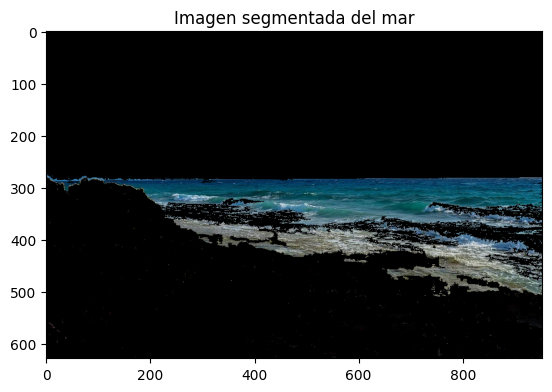

In [6]:
lower_blue = np.array([30, 0, 0])
upper_blue = np.array([250, 250, 170])

mask_mar = cv.inRange(img_hsv, lower_blue, upper_blue)
mask_filled = fill_holes(mask_mar)
mar_segmented = cv.bitwise_and(img_color, img_color, mask=mask_filled)

plt.imshow(cv.cvtColor(mar_segmented, cv.COLOR_BGR2RGB))
plt.title('Imagen segmentada del mar')
plt.show()

# Segmentacion de la Roca

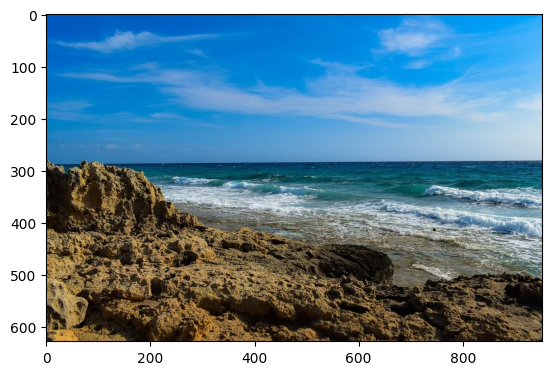

In [12]:
img_color = cv.imread('segmentacion.png')

if img_color is None:
    print("La imagen no se cargó correctamente")
else:
    imgRGB = cv.cvtColor(img_color, cv.COLOR_BGR2RGB)

    plt.figure(1)
    plt.imshow(imgRGB)
    plt.show()

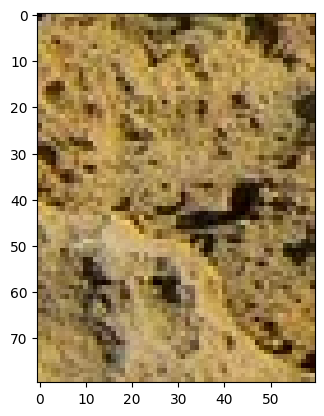

In [13]:
img_muestra_roca = imgRGB[465:545, 0:60,:]
plt.figure(2)
plt.imshow(img_muestra_roca)
plt.show()

In [15]:
color_mean_roca, color_std_roca = cv.meanStdDev(img_muestra_roca)
print(color_mean_roca.flatten().tolist())
print(color_std_roca.flatten().tolist())

[152.24833333333333, 124.52270833333334, 72.75458333333334]
[44.229119335820165, 41.23420789827619, 33.45136674825691]


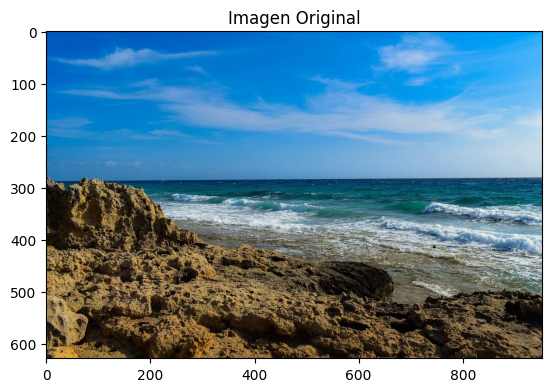

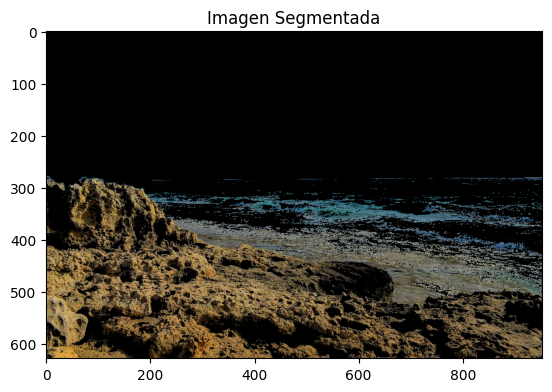

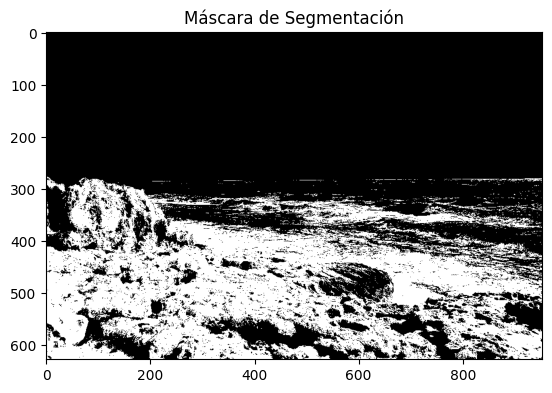

In [16]:
n_sigma = 2.5
mask_roca = cv.inRange(imgRGB, color_mean_roca-color_std_roca * n_sigma,  color_mean_roca+color_std_roca * n_sigma)
img_segmentada_roca = cv.bitwise_and(imgRGB, imgRGB, mask=mask_roca)

plt.figure(99)
plt.imshow(imgRGB)
plt.title('Imagen Original')  # Leyenda para la imagen original
plt.show()

plt.figure(5)
plt.imshow(img_segmentada_roca)
plt.title('Imagen Segmentada') 
plt.show()

plt.figure(6)
plt.imshow(mask_roca,cmap='gray')
plt.title('Máscara de Segmentación') 
plt.show()

# Fin

Aca estoy solo jugando y practicando un poco.

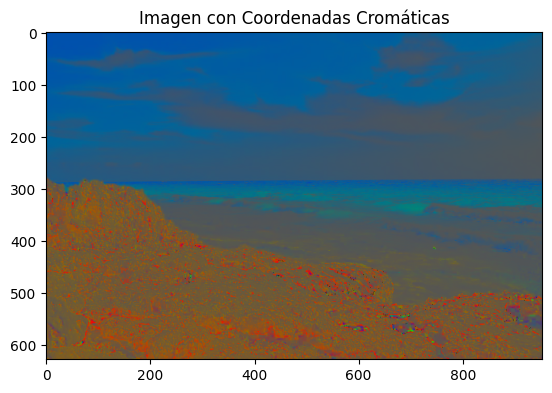

In [17]:
imgRGB_float = imgRGB.astype(np.float32)
color_sum = np.sum(imgRGB_float, axis=2, keepdims=True)
color_sum = np.where(color_sum==0, 1, color_sum)
img_chrom = imgRGB_float / color_sum

plt.figure()
plt.imshow(img_chrom)
plt.title('Imagen con Coordenadas Cromáticas')
plt.show()

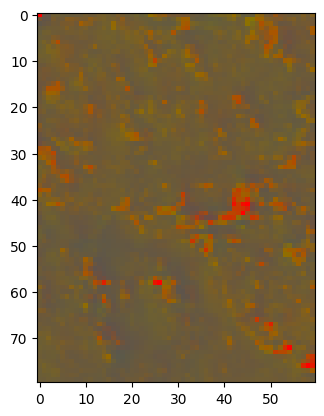

In [18]:
img_muestra_roca_chrom = img_chrom[465:545, 0:60,:]
plt.figure(2)
plt.imshow(img_muestra_roca_chrom)
plt.show()


[0.4526103235719105, 0.3553220959271615, 0.1920675811453839]
[0.06621923756328078, 0.024567131714446605, 0.06202066219310299]


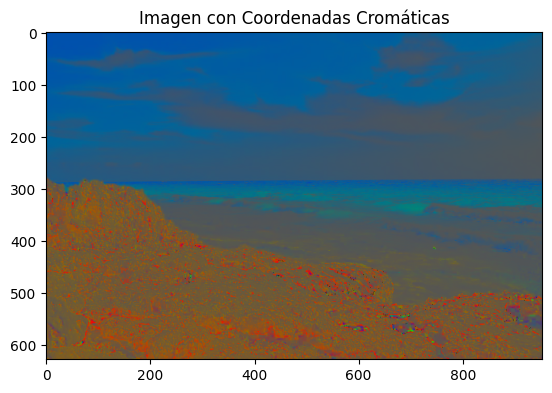

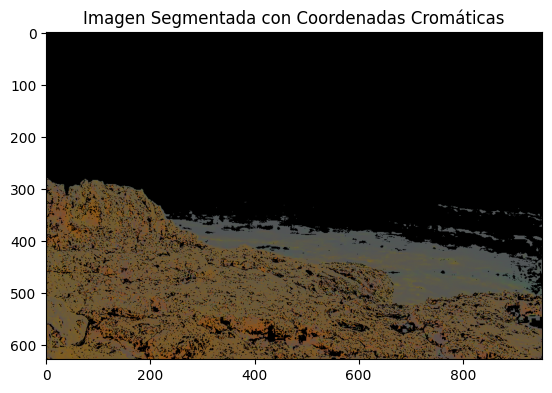

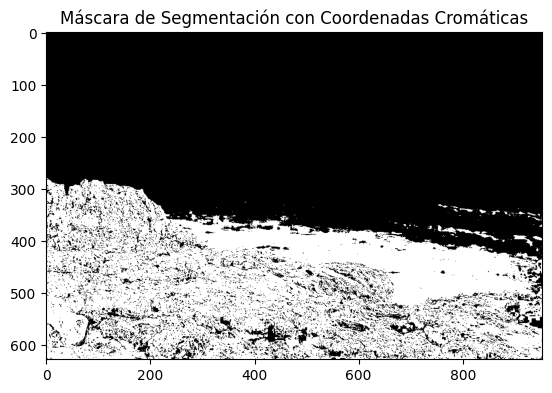

In [22]:
color_mean_roca_chrom, color_std_roca_chrom = cv.meanStdDev(img_muestra_roca_chrom)
print(color_mean_roca_chrom.flatten().tolist())
print(color_std_roca_chrom.flatten().tolist())

n_sigma = 2.5
mask_roca_chrom = cv.inRange(img_chrom, color_mean_roca_chrom-color_std_roca_chrom * n_sigma,  color_mean_roca_chrom+color_std_roca_chrom * n_sigma)
img_segmentada_roca_chrom = cv.bitwise_and(img_chrom, img_chrom, mask=mask_roca_chrom)

plt.figure(99)
plt.imshow(img_chrom)
plt.title('Imagen con Coordenadas Cromáticas') 
plt.show()

plt.figure(5)
plt.imshow(img_segmentada_roca_chrom)
plt.title('Imagen Segmentada con Coordenadas Cromáticas')  
plt.show()

plt.figure(6)
plt.imshow(mask_roca_chrom,cmap='gray')
plt.title('Máscara de Segmentación con Coordenadas Cromáticas')  
plt.show()

White Patch

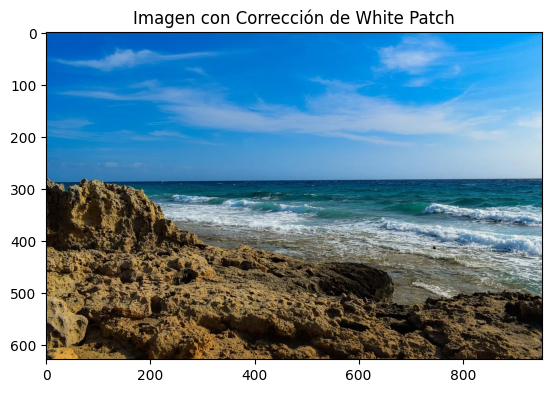

In [20]:
white_patch = np.max(imgRGB_float, axis=(0, 1))
white_patch = np.where(white_patch==0, 1, white_patch)
img_white_patch = imgRGB_float / white_patch

plt.figure()
plt.imshow(img_white_patch)
plt.title('Imagen con Corrección de White Patch')
plt.show()

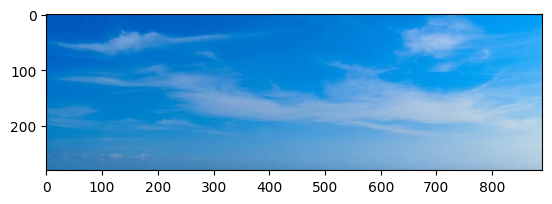

In [194]:
img_muestra_cielo_white_patch = img_white_patch[0:280, 0:890,:]
plt.figure(2)
plt.imshow(img_muestra_cielo_white_patch)
plt.show()

[0.22858188431935547, 0.5804196821233291, 0.8392692004026991]
[0.2178218757547189, 0.10817646550290914, 0.06133056628928642]


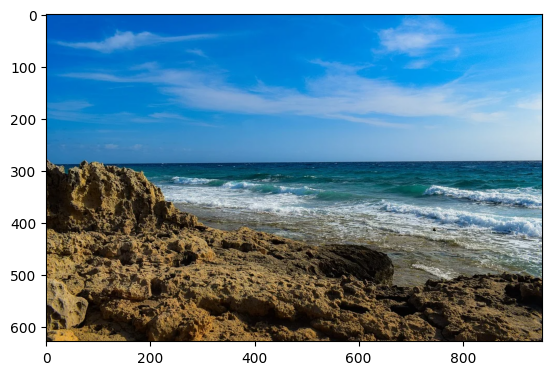

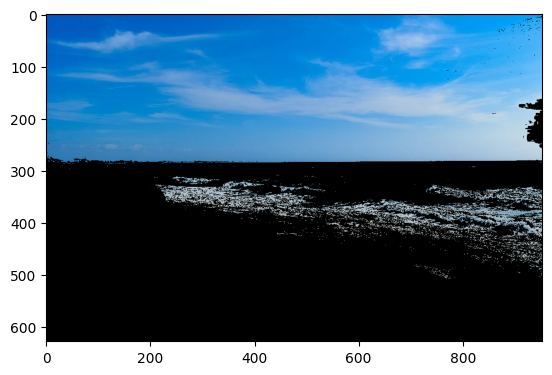

<function matplotlib.pyplot.show(close=None, block=None)>

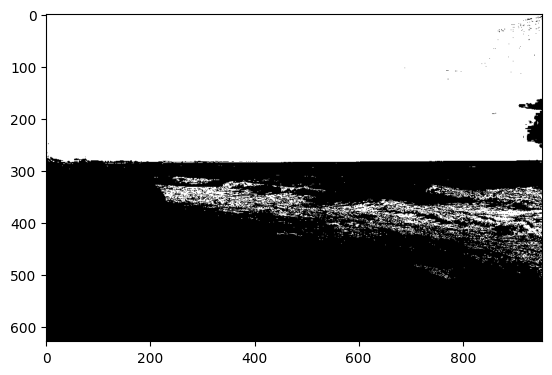

In [195]:
color_mean_cielo_white_patch, color_std_cielo_white_patch = cv.meanStdDev(img_muestra_cielo_white_patch)
print(color_mean_cielo_white_patch.flatten().tolist())
print(color_std_cielo_white_patch.flatten().tolist())

n_sigma = 2.5
mask_cielo_white_patch = cv.inRange(img_white_patch, color_mean_cielo_white_patch-color_std_cielo_white_patch * n_sigma,  color_mean_cielo_white_patch+color_std_cielo_white_patch * n_sigma)
img_segmentada_cielo_white_patch = cv.bitwise_and(img_white_patch, img_white_patch, mask=mask_cielo_white_patch)


plt.figure(99)
plt.imshow(img_white_patch)
plt.show()

plt.figure(5)
plt.imshow(img_segmentada_cielo_white_patch)
plt.show()

plt.figure(6)
plt.imshow(mask_cielo_white_patch,cmap='gray')
plt.show